In [1]:
import pandas as pd
from scipy.stats import pearsonr
import requests
from io import StringIO, BytesIO
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import subprocess
import os
import glob

data_home = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"

In [2]:
#pheno_1 = pd.read_excel("Haemskirt/Unicorn3 Phenotypic data 02042022.xlsx",sheet_name=0)
#pheno_2 = pd.read_excel("Haemskirt/Unicorn3 Phenotypic data 02042022.xlsx",sheet_name=2)
#pheno = pd.merge(pheno_1,pheno_2,left_on="CFT ID",right_on="CFT ID")

# Read phenotype table

## Read

In [2]:
pheno_df = pd.read_excel("Haemskirt/05102022 Unicorn2-3_thrombus formation.xlsx",sheet_name=0)

In [4]:
pheno_df.head(5)

,Study,CFT ID,DATE,Donor,Proteomics,rs10886430 Genotype,rs10886430_minor_allele_count,rs4148436 Genotype,rs4148436_minor_allele_count,M1 P1,...,Unnamed: 177,Unnamed: 178,Unnamed: 179,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186
0,Unicorn2,C0WX14,2016-01-12 00:00:00,C0WX14,No,AA,0,AA,0,49.795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Unicorn2,C0WX4Z,2016-01-12 00:00:00,C0WX4Z,No,AA,0,AA,0,33.290,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Unicorn2,C0WX6V,2016-01-12 00:00:00,C0WX6V,No,AA,0,AA,0,44.080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Unicorn2,C0WX7T,2016-01-12 00:00:00,C0WX7T,No,AA,0,AG,1,49.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Unicorn2,C0WX8R,2016-01-12 00:00:00,C0WX8R,No,AA,0,AA,0,41.005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
matching_affy_IDs = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/unicorn/05102022_Unicorn2-3_thrombus_formation_with_Affy.tsv", sep="\t", header=None)

## Match IDs

In [6]:
matching_df = matching_affy_IDs.rename(columns={1:"CFT ID",67:"affy_ID"})
matching_df = matching_df.loc[~matching_df.affy_ID.isnull()]
matching_df.head(5)

,0,CFT ID,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,affy_ID
0,Unicorn2,C0WX14,12/01/2016,C0WX14,No,AA,0,AA,0,49.80,...,17.60,6.49,17.97,24.72,8.40,94.24,102.64,1692.0,1515.0,a550484-4324983-042818-483_D02
1,Unicorn2,C0WX4Z,12/01/2016,C0WX4Z,No,AA,0,AA,0,33.29,...,19.28,16.54,25.25,28.00,10.88,108.99,119.87,1676.0,1516.0,a550484-4324983-042818-483_D04
2,Unicorn2,C0WX6V,12/01/2016,C0WX6V,No,AA,0,AA,0,44.08,...,25.98,29.36,33.42,34.00,12.93,150.00,162.93,1629.0,1517.0,a550484-4324983-042818-483_E02
3,Unicorn2,C0WX7T,12/01/2016,C0WX7T,No,AA,0,AG,1,49.01,...,20.53,12.80,12.66,28.06,11.19,94.59,105.78,1637.0,1006.0,a550484-4324983-042818-483_E04
4,Unicorn2,C0WX8R,12/01/2016,C0WX8R,No,AA,0,AA,0,41.01,...,23.90,15.49,25.05,27.02,12.80,116.08,128.87,1679.0,1519.0,a550484-4327674-062018-906_D01


In [7]:
pheno_df = pheno_df.merge(matching_df[["CFT ID","affy_ID"]], left_on="CFT ID", right_on="CFT ID",how="left")
pheno_df["affy_ID"] = pheno_df["affy_ID"] + ".CEL"

# QC of phenotype

In [8]:
raw_pheno_cols = [c for c in pheno_df.columns if c[0] == "M" and c[3] == "P"]
signature_cols = [c for i, c in enumerate(pheno_df.columns) if "sig" in c.lower()][:-2]
pheno_cols = raw_pheno_cols + signature_cols

In [9]:
signature_cols

['M1 Thr signature',
 'M2 Thr signature',
 'M3 Thr signature',
 'M4 Thr signature',
 'M5 Thr signature',
 'M6 Thr signature']

In [10]:
", ".join(raw_pheno_cols)

'M1 P1, M1 P2, M1 P3, M1 P4, M1 P5, M1 P6 , M1 P7, M1 P8, M2 P1, M2 P2, M2 P3, M2 P4, M2 P5 , M2 P6, M2 P7, M2 P8, M3 P1, M3 P2, M3 P3, M3 P4, M3 P5, M3 P6, M3 P7, M3 P8, M4 P1, M4 P2, M4 P3, M4 P4, M4 P5, M4 P6, M4 P7, M4 P8, M5 P1, M5 P2, M5 P3, M5 P4, M5 P5, M5 P6, M5 P7, M5 P8, M6 P1, M6 P2, M6 P3, M6 P4, M6 P5, M6 P6, M6 P7, M6 P8'

In [11]:
print(pheno_df.shape)
pheno_df = pheno_df.loc[pheno_df[pheno_cols].isnull().sum(axis=1) == 0]
print(pheno_df.shape)

(194, 188)
(187, 188)


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


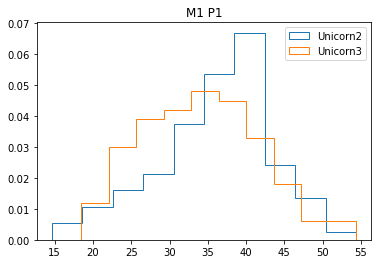

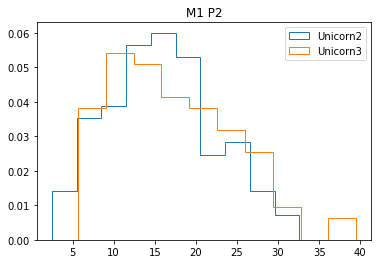

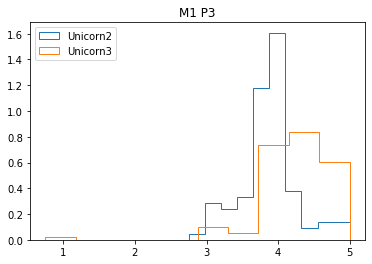

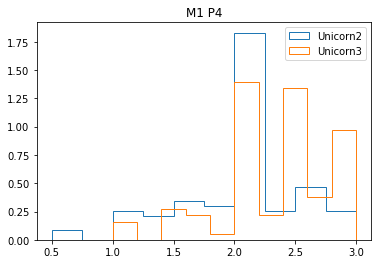

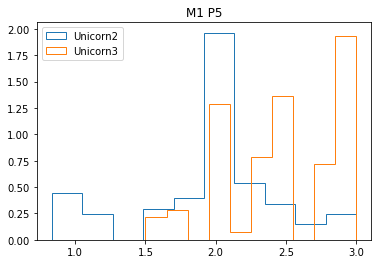

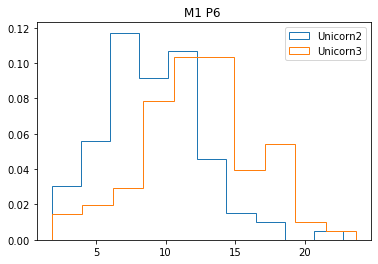

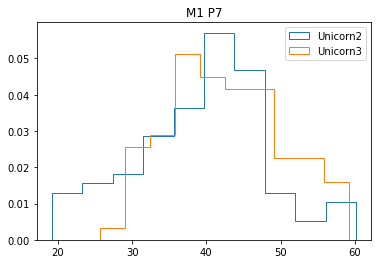

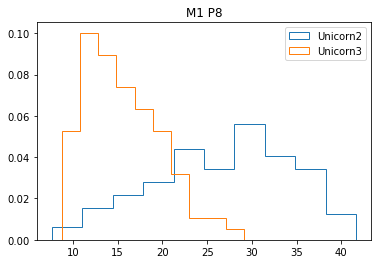

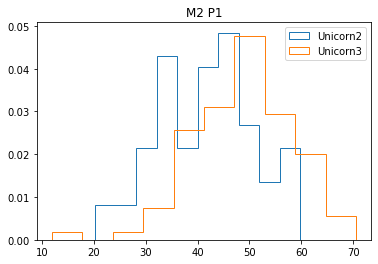

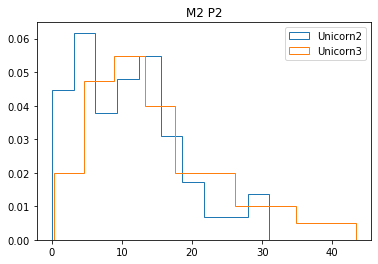

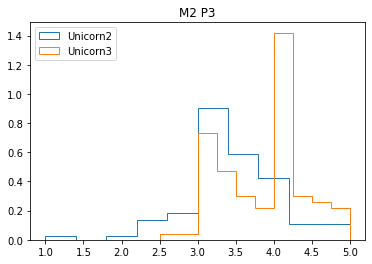

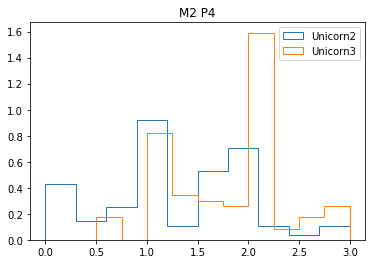

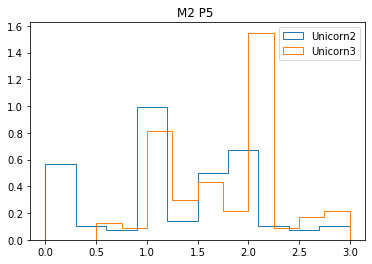

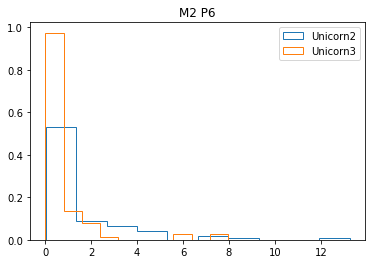

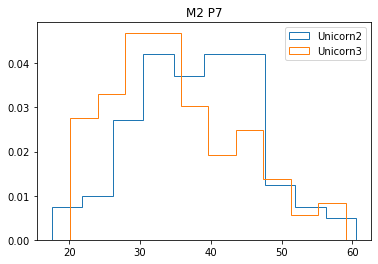

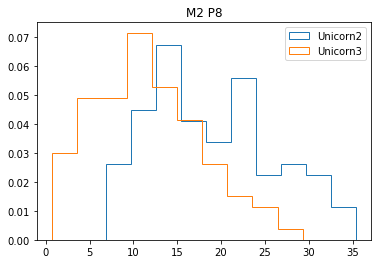

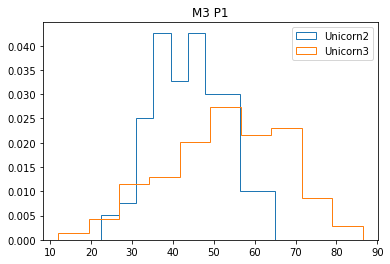

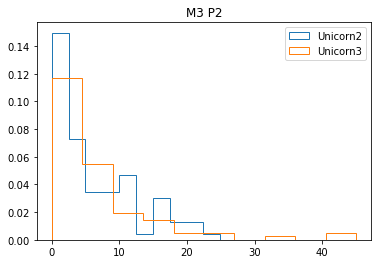

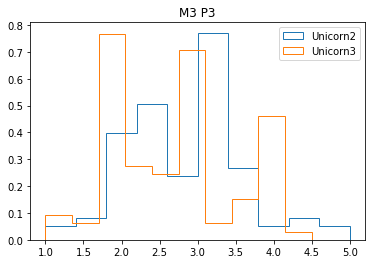

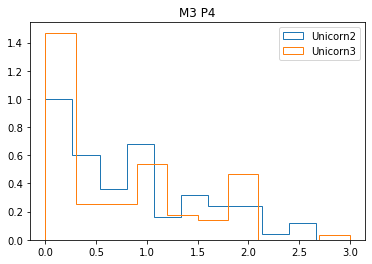

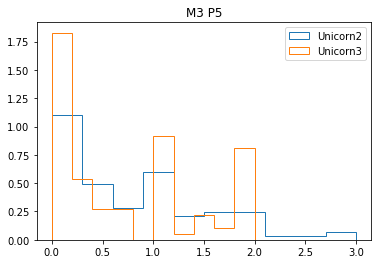

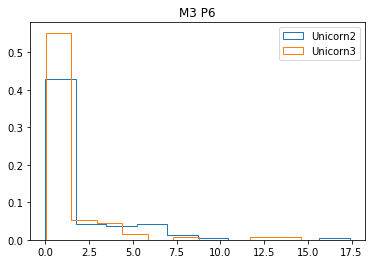

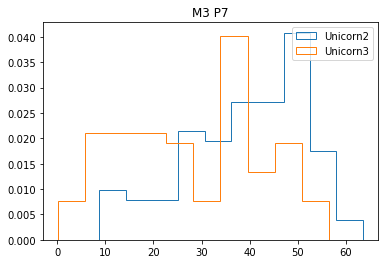

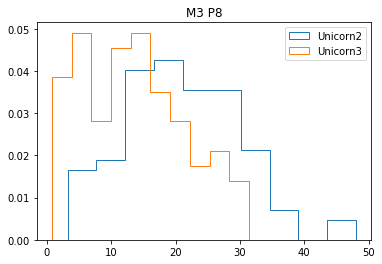

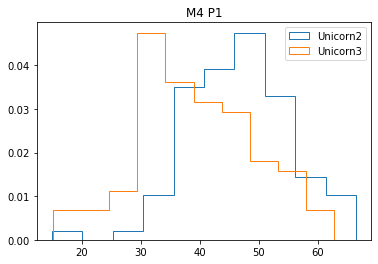

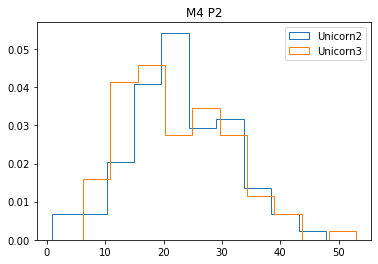

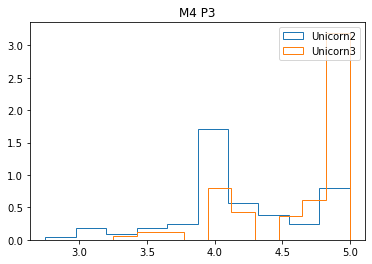

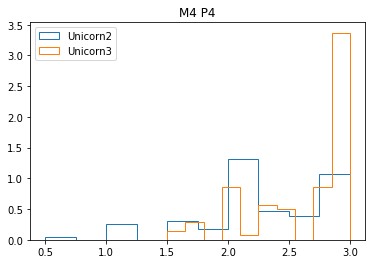

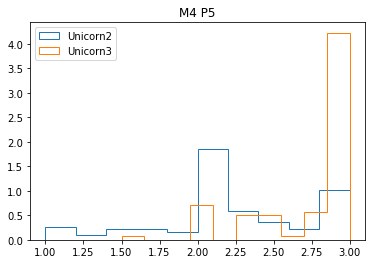

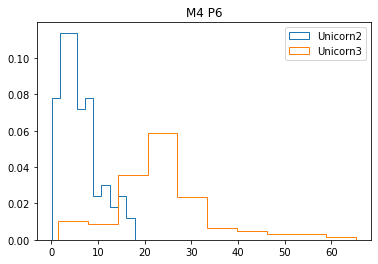

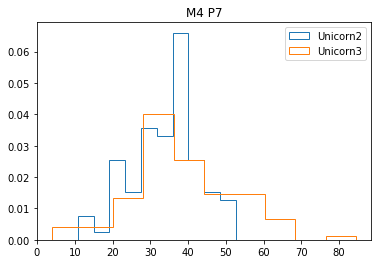

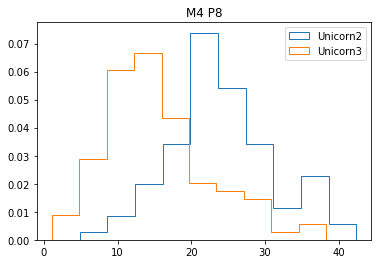

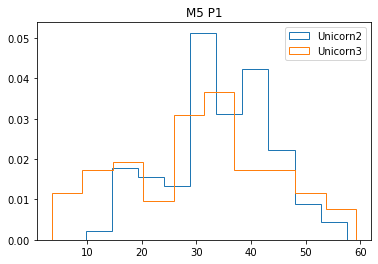

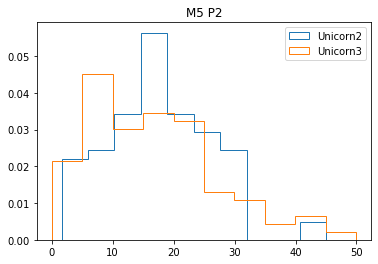

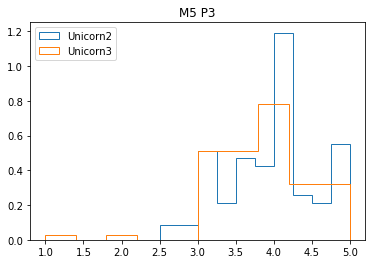

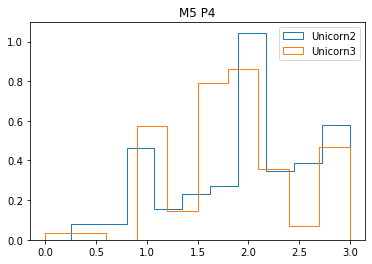

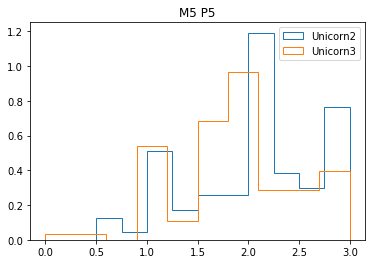

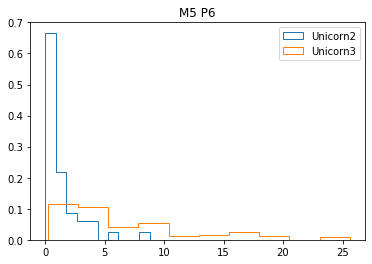

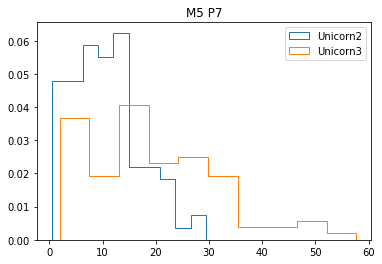

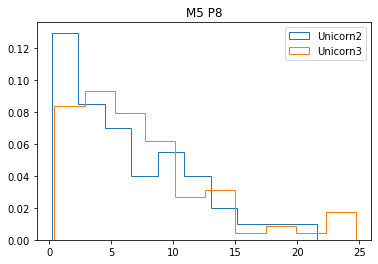

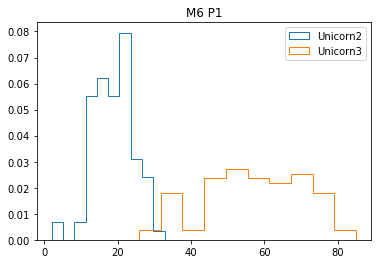

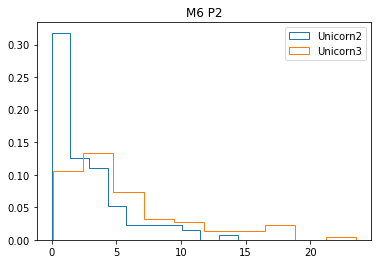

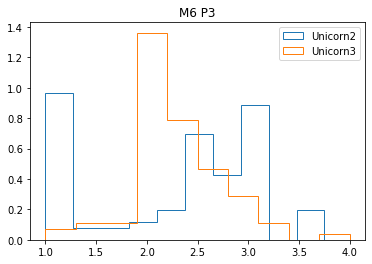

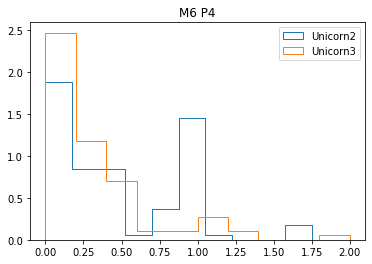

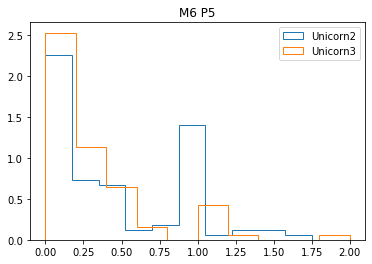

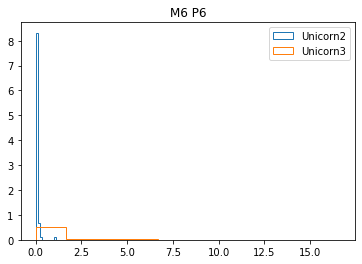

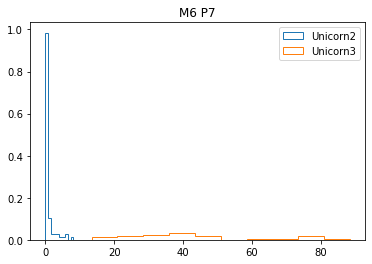

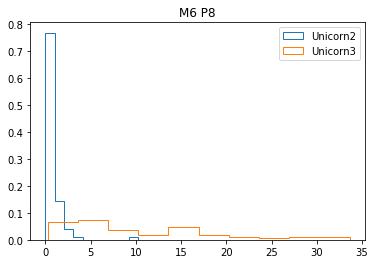

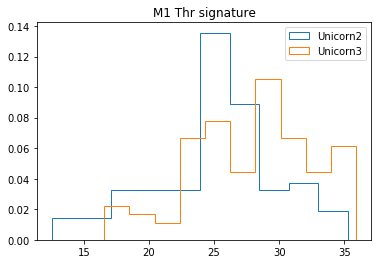

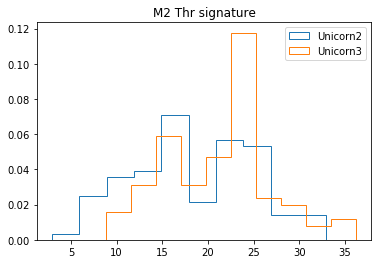

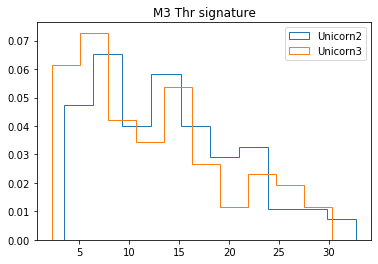

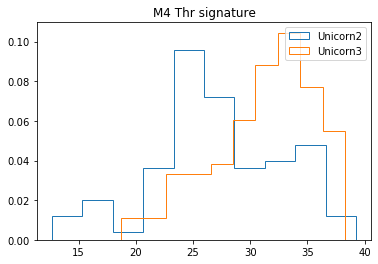

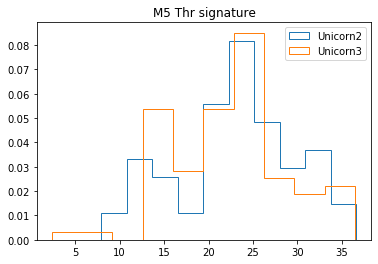

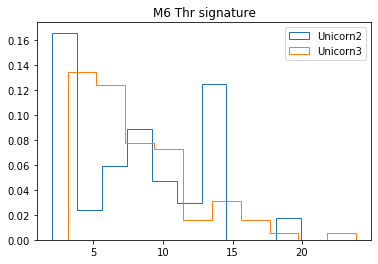

In [12]:
for c in pheno_cols:
    plt.figure()
    for study, df in pheno_df.groupby("Study"):
        plt.hist(df[c],density=True,histtype="step",label=study)
    plt.title(c)
    plt.legend()

## Adjust per cohort

In [13]:
for study, df in pheno_df.groupby("Study"):
    pheno_df.loc[pheno_df.Study == study,pheno_cols] -= df[pheno_cols].mean(axis=0)
    pheno_df.loc[pheno_df.Study == study,pheno_cols] /= df[pheno_cols].std(axis=0)

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


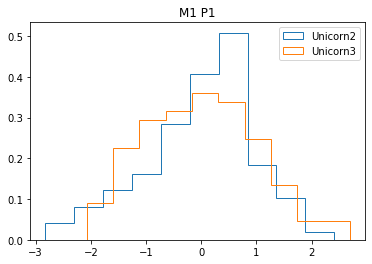

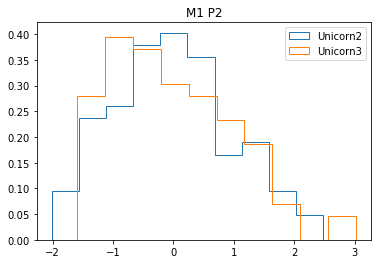

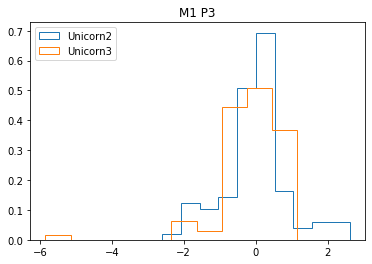

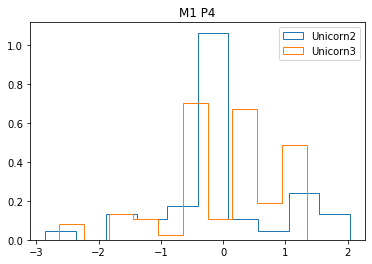

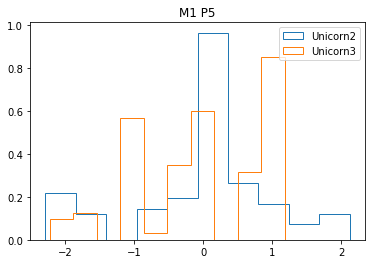

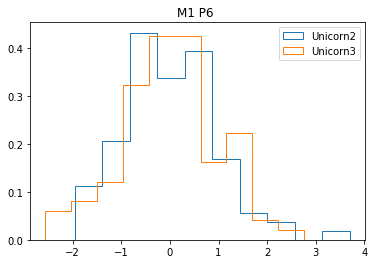

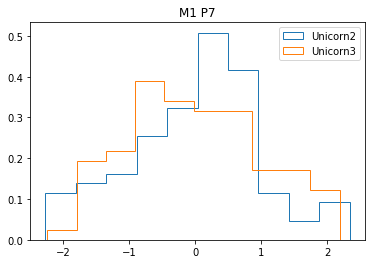

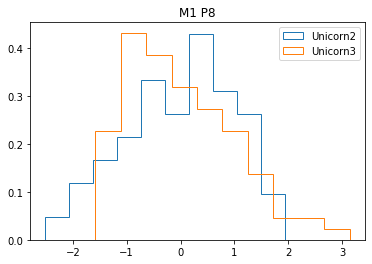

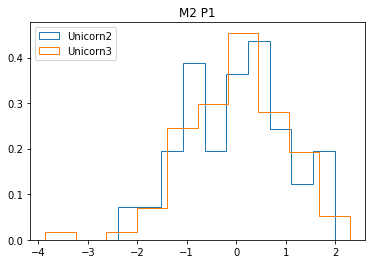

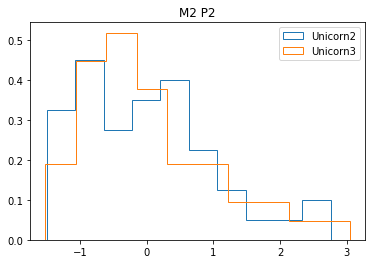

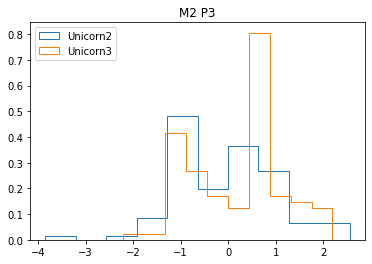

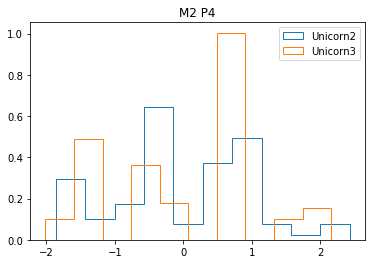

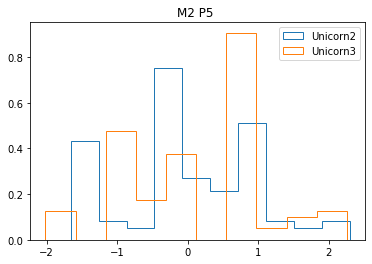

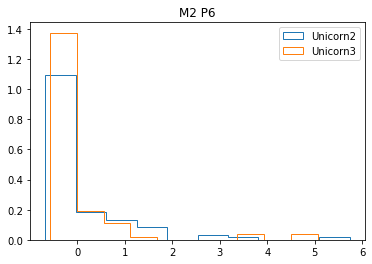

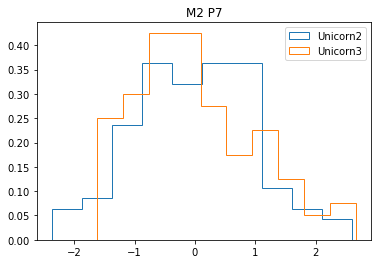

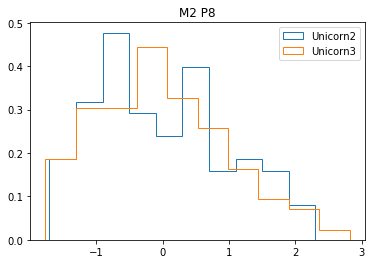

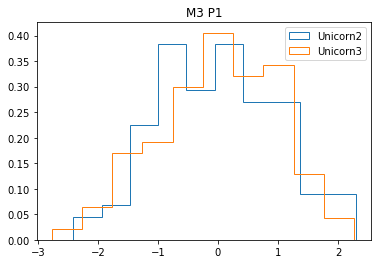

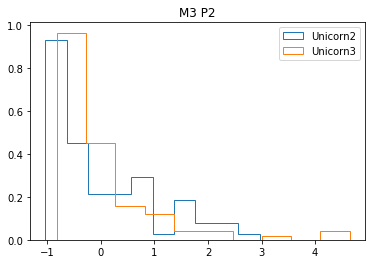

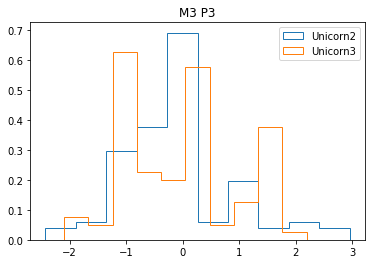

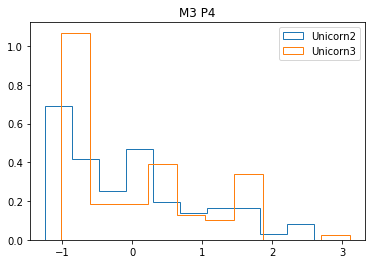

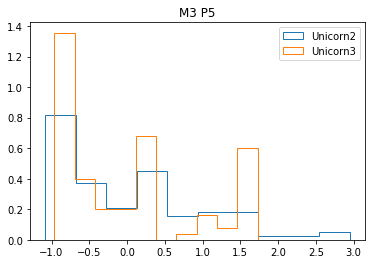

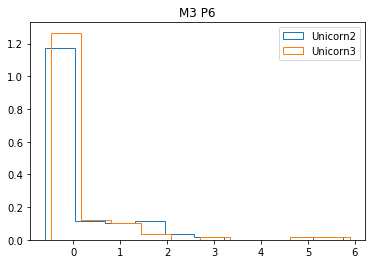

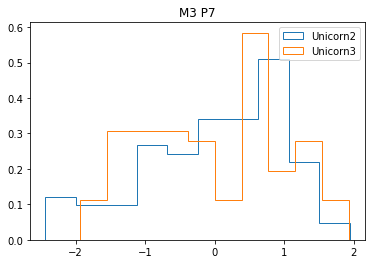

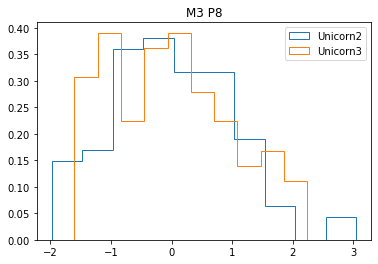

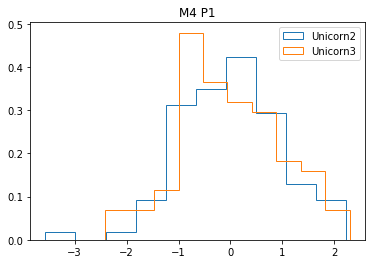

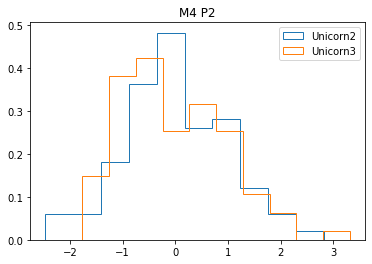

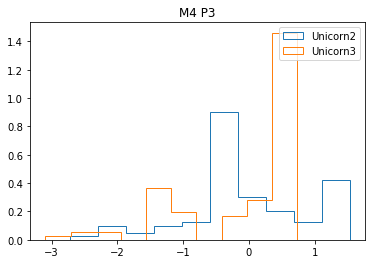

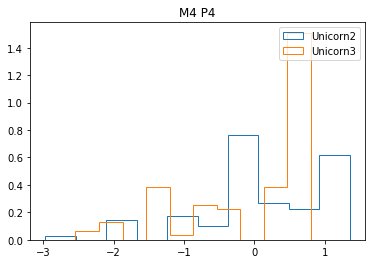

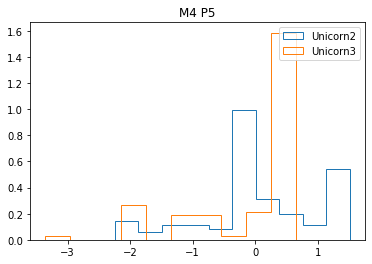

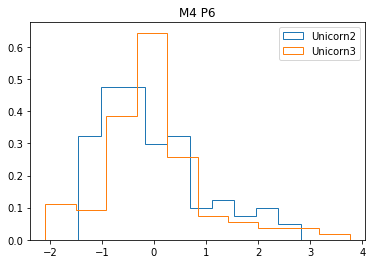

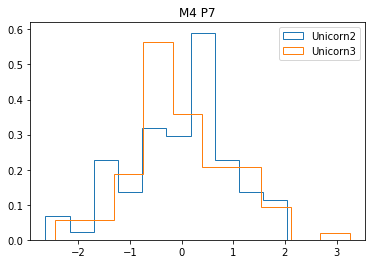

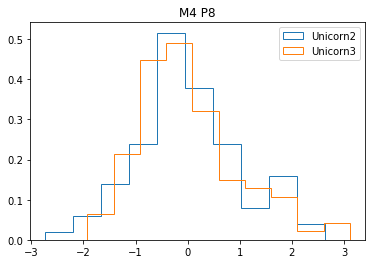

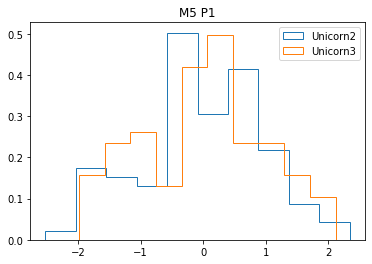

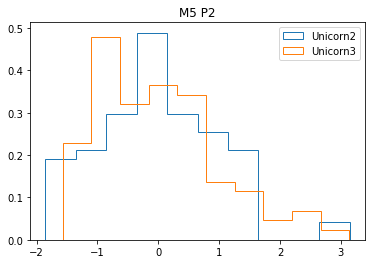

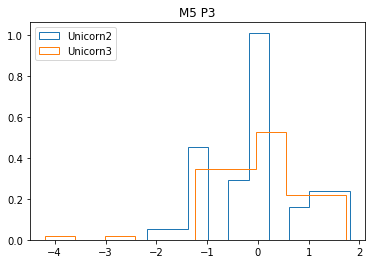

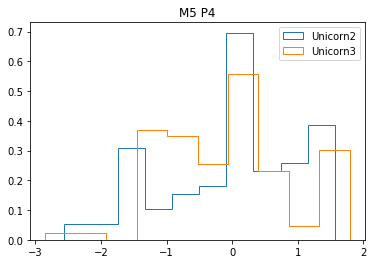

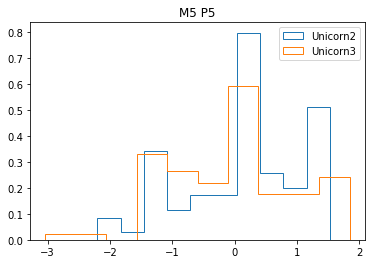

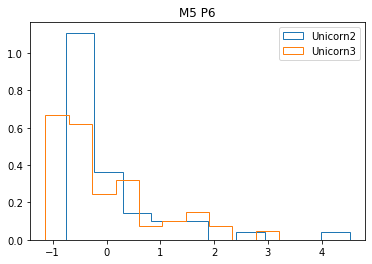

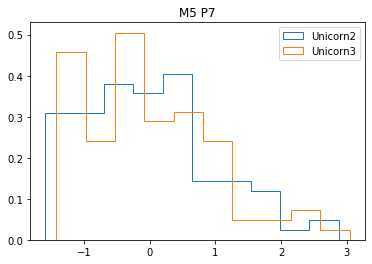

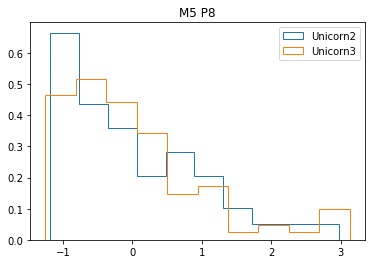

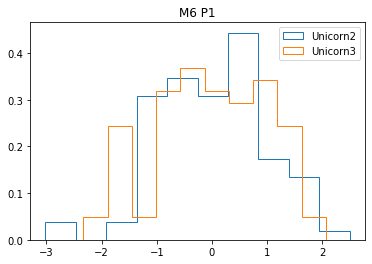

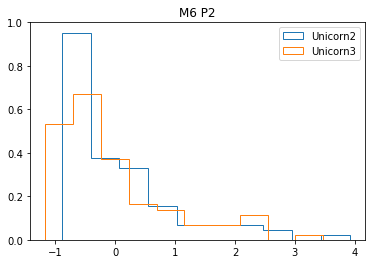

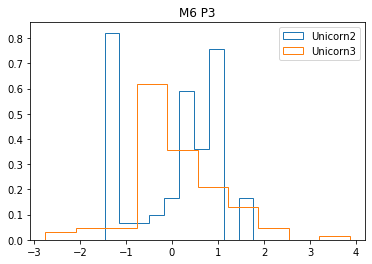

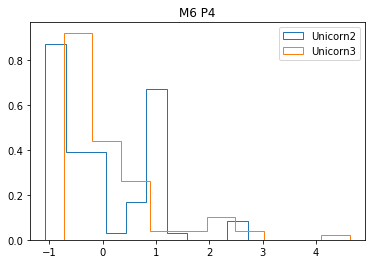

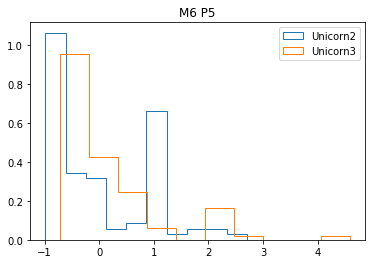

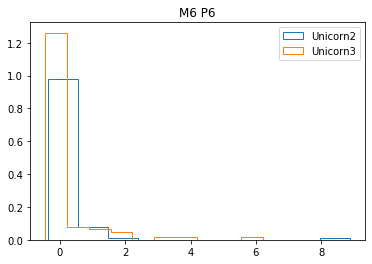

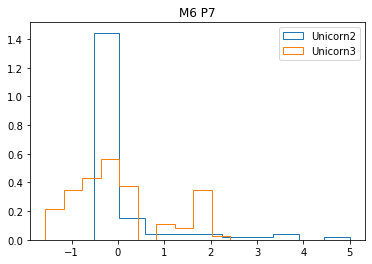

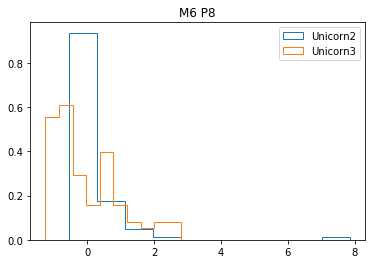

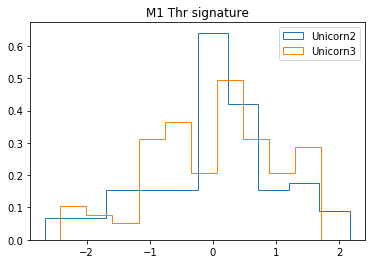

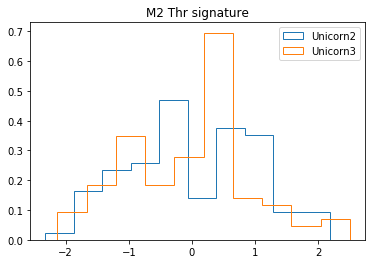

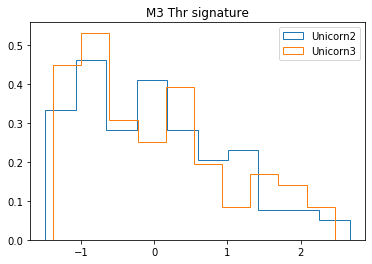

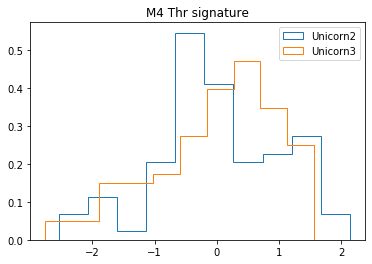

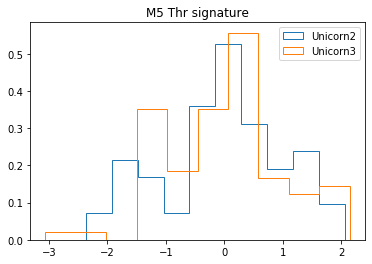

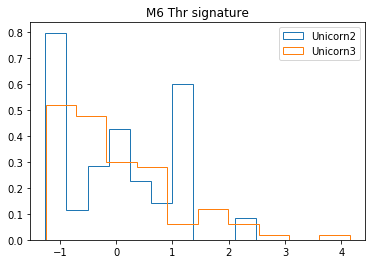

In [14]:
for c in pheno_cols:
    plt.figure()
    for study, df in pheno_df.groupby("Study"):
        plt.hist(df[c],density=True,histtype="step",label=study)
    plt.title(c)
    plt.legend()

## Cross-correlation

In [15]:
C = np.cov(pheno_df[signature_cols].values.T)

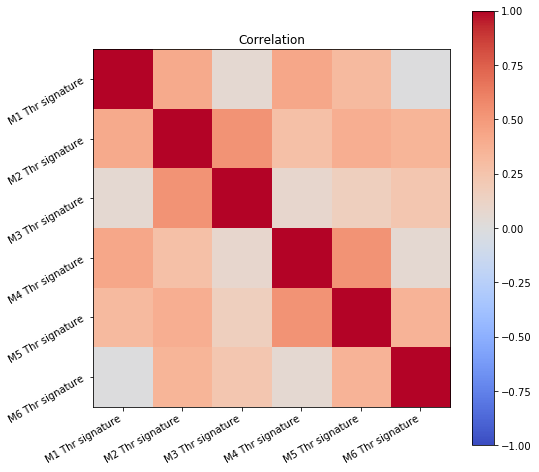

In [16]:
plt.figure(figsize=(8,8))
plt.xticks(np.arange(C.shape[0]),signature_cols,rotation=30,ha="right")
plt.yticks(np.arange(C.shape[0]),signature_cols,rotation=30,ha="right")
plt.imshow(C,vmin=-1,vmax=1,cmap="coolwarm")
plt.title("Correlation")
plt.colorbar()

In [17]:
C.shape[0]

6

In [18]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

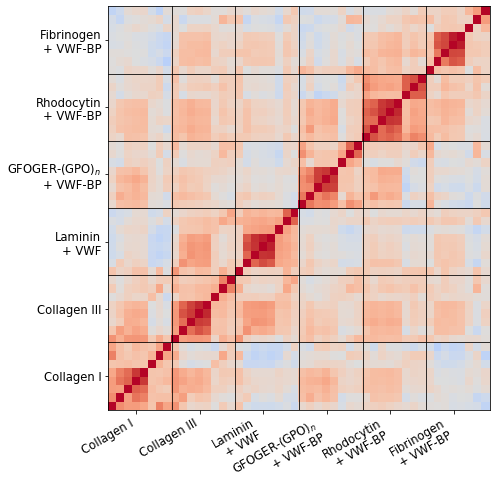

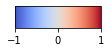

In [19]:
C = np.cov(pheno_df[raw_pheno_cols].values.T)

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
plt.xticks(
    np.array([4, 12, 20, 28, 36, 44])-.5,
    ["Collagen I",
     "Collagen III",
     "Laminin\n+ VWF",
     "GFOGER-(GPO)$_n$\n+ VWF-BP",
     "Rhodocytin\n+ VWF-BP",
     "Fibrinogen\n+ VWF-BP"
    ],rotation=30,ha="right",fontsize=11.6)
plt.yticks(
    np.array([4, 12, 20, 28, 36, 44]),
    ["Collagen I",
     "Collagen III",
     "Laminin\n+ VWF",
     "GFOGER-(GPO)$_n$\n+ VWF-BP",
     "Rhodocytin\n+ VWF-BP",
     "Fibrinogen\n+ VWF-BP"
    ],rotation=0,ha="right",fontsize=11.6)
im = plt.pcolormesh(C,vmin=-1,vmax=1,cmap="coolwarm",)
for i in range(5):
    plt.axvline(8+i*8,c="black",lw=.8)
    plt.axhline(8+i*8,c="black",lw=.8)

plt.tight_layout()
plt.savefig("figures/Heemskerk_corr.pdf")

#axins1 = inset_axes(
#    ax1,
#    width="12%",  # width: 50% of parent_bbox width
#    height="4%",  # height: 5%
#    loc="upper right",
#)
#axins1.xaxis.set_ticks_position("bottom")

fig = plt.figure(figsize=(1.5,1.5))
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.2])
plt.colorbar(
    im, cax=cax, orientation="horizontal", ticks=[-1, 0,1])
plt.savefig("figures/rho_colorbar.pdf", transparent=True)

## PCA

In [20]:
pca_raw = PCA()#n_components="mle"
pca_raw.fit(pheno_df[raw_pheno_cols])
pca_raw.components_[0]*=-1

Text(0.5, 0, 'Component index')

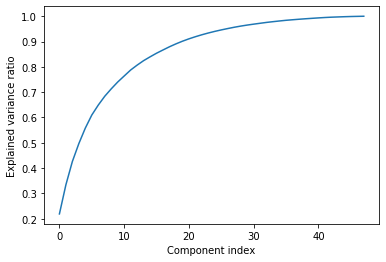

In [21]:
#plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca_raw.explained_variance_ratio_))
#plt.yscale("log")
plt.ylabel("Explained variance ratio")
plt.xlabel("Component index")

In [22]:
pca_signatures = PCA()
pca_signatures.fit(pheno_df[signature_cols])

PCA()

Text(0.5, 0, 'Component index')

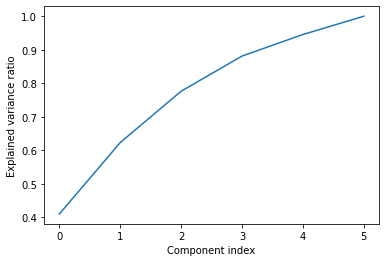

In [23]:
#plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca_signatures.explained_variance_ratio_))
#plt.yscale("log")
plt.ylabel("Explained variance ratio")
plt.xlabel("Component index")

In [24]:
sig_pc_cols = ["sig_PC_%d" % i for i in range(1,5)]
raw_pc_cols = ["raw_PC_%d" % i for i in range(1,5)]
pheno_df[sig_pc_cols] = pca_signatures.transform(pheno_df[signature_cols])[:,:4]
pheno_df[raw_pc_cols] = pca_raw.transform(pheno_df[raw_pheno_cols])[:,:4]

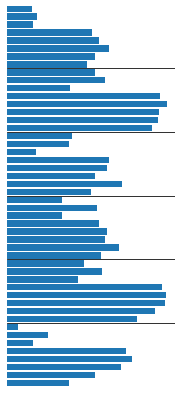

In [25]:
fig = plt.figure(figsize=(3,7))
plt.barh(y=np.arange(len(pca_raw.components_[0]))+.5,
         height=.8,
         width=pca_raw.components_[0])
plt.ylim((0,len(pca_raw.components_[0])-.2))
for i in range(5):
    plt.axhline(8+i*8,c="black",lw=.8)
plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.savefig("figures/PC1_loadings.pdf")

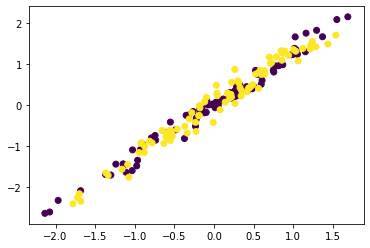

In [26]:
plt.scatter(
    pheno_df[["M1 P2","M1 P3","M1 P4","M1 P5","M1 P8"]].mean(axis=1), 
    pheno_df[["M1 Thr signature"]],
    c=pheno_df["Study"] == "Unicorn3")

In [27]:
#export_pheno = pheno[["Donor"] + list(pheno_cols)]
#export_pheno = pheno[["affy_ID"] + list(pheno_cols) + list(pc_cols)]
export_pheno = pheno_df[["affy_ID"] + list(raw_pc_cols) + list(sig_pc_cols)]
export_pheno = export_pheno.loc[~export_pheno.affy_ID.isnull()]
export_pheno["IID"] = export_pheno["affy_ID"]
export_pheno["FID"] = export_pheno["affy_ID"]
del export_pheno["affy_ID"]
print("%d donors" % export_pheno.shape[0])
for c in export_pheno.columns:
    export_pheno = export_pheno.rename(columns={c:"_".join(c.split(" "))})
export_pheno = export_pheno[["FID","IID"] + list(export_pheno.columns[:-2])]
#export_pheno = export_pheno.rename(columns={"IID":"#IID"})
export_pheno.head()

87 donors


,FID,IID,raw_PC_1,raw_PC_2,raw_PC_3,raw_PC_4,sig_PC_1,sig_PC_2,sig_PC_3,sig_PC_4
0,a550484-4324983-042818-483_D02.CEL,a550484-4324983-042818-483_D02.CEL,0.382404,-0.756080,4.428548,-5.772696,0.728955,-0.045176,0.313780,1.455349
1,a550484-4324983-042818-483_D04.CEL,a550484-4324983-042818-483_D04.CEL,0.721373,2.559071,2.550689,-0.259778,-0.175467,1.021889,0.829221,-0.577121
2,a550484-4324983-042818-483_E02.CEL,a550484-4324983-042818-483_E02.CEL,5.962166,1.552377,-0.379703,-1.018572,-3.033926,0.941740,-0.048126,-0.961862
3,a550484-4324983-042818-483_E04.CEL,a550484-4324983-042818-483_E04.CEL,0.806992,3.473059,4.746305,-4.943331,0.741231,1.807576,0.787706,0.823617
4,a550484-4327674-062018-906_D01.CEL,a550484-4327674-062018-906_D01.CEL,2.050529,1.438217,2.358094,-1.802141,-0.894244,0.911227,0.501421,0.426377


In [28]:
#export_pheno.loc[export_pheno["#IID"] == "a550484-4324983-042818-483_D02.CEL"]

In [29]:
print("%s/cleaned_haemskerk.csv" % data_home)

/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home/cleaned_haemskerk.csv


In [30]:
export_pheno.to_csv("%s/cleaned_haemskerk.csv" % data_home,index=False,sep="\t",header=True)

# Do GWAS

In [71]:
proxies = {
    "rs11078475":"17:3819002[b37]T,C",
    "rs1654425":"19:55538980[b37]T,C",
    "rs3819288":"rs17881225",
    "rs59001897":"rs12905925",
}

In [94]:
for f in glob.glob("%s/hameskerk_results/*" % data_home):
    os.remove(f)

for k in range(1,23):
    print("Doing chromosome %d" % k)
    command = "/home/hv270/plink2"
    command += " --bgen /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_genotypes/bgen/PFC.%d.imputed.non_zero_maf.bgen 'ref-last'" % k
    command += " --sample /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_genotypes/bgen/PFC.%d.imputed.non_zero_maf.sample" % k
    command += " --glm sex 'hide-covar'"
    command += " --pheno %s/cleaned_haemskerk.csv" % (data_home)
    command += " --out %s/hameskerk_results/pfc_chr_%d" % (data_home,k)
    command += " --allow-no-sex"
    command += " --maf 0.00"
    command += " --mac 0"
    command += " --variance-standardize"
    p = subprocess.Popen(command,shell=True)
    p.wait()

Doing chromosome 1
Doing chromosome 2
Doing chromosome 3
Doing chromosome 4
Doing chromosome 5
Doing chromosome 6
Doing chromosome 7
Doing chromosome 8
Doing chromosome 9
Doing chromosome 10
Doing chromosome 11
Doing chromosome 12
Doing chromosome 13
Doing chromosome 14
Doing chromosome 15
Doing chromosome 16
Doing chromosome 17
Doing chromosome 18
Doing chromosome 19
Doing chromosome 20
Doing chromosome 21
Doing chromosome 22


# Read GWAS

In [2]:
export_pheno = pd.read_csv("%s/cleaned_haemskerk.csv" % data_home,sep="\t")
export_pheno.sample(3)

,FID,IID,raw_PC_1,raw_PC_2,raw_PC_3,raw_PC_4,sig_PC_1,sig_PC_2,sig_PC_3,sig_PC_4
0,a550484-4324983-042818-483_D02.CEL,a550484-4324983-042818-483_D02.CEL,0.382404,-0.756080,4.428548,-5.772696,0.728955,-0.045176,0.313780,1.455349
13,a550484-4324983-042818-483_A04.CEL,a550484-4324983-042818-483_A04.CEL,-5.233225,-1.652039,-1.084316,-1.274832,2.413406,-0.894817,-0.231986,0.561065
45,a550484-4326140-061918-704_F11.CEL,a550484-4326140-061918-704_F11.CEL,6.481799,-2.443492,-1.490872,-0.510212,-3.203989,-1.459885,-0.305873,0.168085


In [3]:
dfs = []
for k in range(1,23):
    for col in ["raw_PC_1"]:
        f = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home/hameskerk_results/pfc_chr_%d.%s.glm.linear" % (k,col)
        if not os.path.exists(f): continue
        df = pd.read_csv(f,sep="\t")
        df["pheno"] = col
        dfs.append(df)
df = pd.concat(dfs,axis=0,ignore_index=True)

In [4]:
interval_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
mix = pd.read_csv("%s/PFC_INTERVAL_comparison_with_proxies.csv" % interval_folder,index_col=0)
mix[["CHR_PFC","POS_PFC"]] = mix[["CHR_PFC","POS_PFC"]].astype(int)

In [5]:
df = df.loc[df.pheno == "raw_PC_1"]

In [6]:
#df.loc[~df.BETA.isnull() & (df.ID != ".") & (df.REF == df.A1),["#CHROM","ID","REF","ALT","A1","BETA"]].sort_values("BETA").iloc[0]

In [7]:
df.loc[df.ID == "rs1354034"] # ARGHEF3

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,pheno
4952411,3,56849749,rs1354034,T,C,T,ADD,87,-0.219246,0.152107,-1.4414,0.15319,raw_PC_1


In [8]:
# We have one variant where A1 and ALT differ : rs1126281
# Check which one is the effect allele

In [9]:
# Extract genotype for SNP
# SNP = "rs1126281"
SNP = "rs1354034"
k = 3
with open("/home/hv270/singleSNP","w") as f:
    f.write(SNP)
command = "/home/hv270/plink2"
command += " --bgen /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_genotypes/bgen/PFC.%d.imputed.non_zero_maf.bgen 'ref-last'" % k
command += " --sample /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_genotypes/bgen/PFC.%d.imputed.non_zero_maf.sample" % k
command += " --pheno %s/cleaned_haemskerk.csv" % (data_home)
command += " --extract /home/hv270/singleSNP"
command += " --export A"
command += " --out %s/hameskerk_results/test_single_SNP" % (data_home)

p = subprocess.Popen(command,shell=True)
p.wait()

0

In [10]:
gen = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home/hameskerk_results/test_single_SNP.raw",sep="\t")

In [11]:
comp_gen = gen.merge(export_pheno,left_on="FID",right_on="FID",how="inner")[["FID","raw_PC_1"] + [gen.columns[-1]]]
comp_gen.groupby(gen.columns[-1]).agg({"raw_PC_1":["mean"]})

,raw_PC_1
,mean
rs1354034_T,
0,0.656054
1,-0.086051
2,-0.740174


In [12]:
# T (= A1) is the effect allele !

In [18]:
comp.columns

Index(['RSID_PFC', 'CHR_PFC', 'POS_PFC', 'REF_PFC', 'ALT_PFC', 'AAF_PFC',
       'MINOR_PFC', 'MAF_PFC', 'ALT_MINOR_PFC', 'REF_COUNT_PFC',
       'ALT_COUNT_PFC', 'INFO_PFC', 'BETA_PFC', 'SE_PFC', 'MLOG10P_PFC',
       'best_agonist_PFC', 'hit_rank_PFC', 'BP_PFC', 'SNP_PFC', 'SNP_INTERVAL',
       'CHR_INTERVAL', 'BP_INTERVAL', 'GENPOS_INTERVAL', 'ALLELE1_INTERVAL',
       'ALLELE0_INTERVAL', 'A1FREQ_INTERVAL', 'INFO_INTERVAL',
       'CHISQ_LINREG_INTERVAL', 'P_LINREG_INTERVAL', 'BETA_INTERVAL',
       'SE_INTERVAL', 'CHISQ_BOLT_LMM_INF_INTERVAL', 'P_BOLT_LMM_INF_INTERVAL',
       'CHISQ_BOLT_LMM_INTERVAL', 'P_BOLT_LMM_INTERVAL', 'proxy_for',
       'homogenous_BETA', 'homogenous_SE', '#CHROM_HSK', 'POS_HSK', 'ID_HSK',
       'REF_HSK', 'ALT_HSK', 'A1_HSK', 'TEST_HSK', 'OBS_CT_HSK', 'BETA_HSK',
       'SE_HSK', 'T_STAT_HSK', 'P_HSK', 'pheno_HSK', 'SNP', 'SYMBOL'],
      dtype='object')

In [19]:
# HSK : Heemskerk
comp = mix.merge(df.add_suffix("_HSK"), right_on=["#CHROM_HSK","POS_HSK"],left_on=["CHR_PFC","POS_PFC"],how="left").copy()
effect_allele_differs = comp["ALLELE1_INTERVAL"] != comp["A1_HSK"]
comp["BETA_INTERVAL"] *= -1
hsk_pfc_effect_differs = comp["A1_HSK"] != comp["ALT_PFC"]
comp.loc[hsk_pfc_effect_differs,"BETA_HSK"] *= -1
# -> On est bien dans la convention REF/ALT de PFC


#comp.loc[effect_allele_differs,"A1_HSK"] = comp.loc[effect_allele_differs,"ALLELE1_INTERVAL"]
#comp.loc[effect_allele_differs,"BETA_HSK"] *= -1
# Standardize so that the score STD is 1
scores = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % interval_folder,key="scores")
score_std = scores["best_pval_score_homogenous"].std()
comp[["BETA_INTERVAL","SE_INTERVAL"]] /= score_std
print(pearsonr(comp["BETA_INTERVAL"],comp["BETA_HSK"]))
# Get gene names
gene_hits = pd.read_csv("GWAS_table.csv",index_col=0)
gene_hits.sample(3)
comp = comp.merge(gene_hits[["SNP","SYMBOL"]],left_on="proxy_for",right_on="SNP")

(0.5782904410352759, 0.00603137746655966)


In [20]:
comp = comp.replace({"RP11-16L9.4":"PTPRC",
              "OR2C3":"GCSAML",
              "ANKMY1":"RNPEPL1",
              "MRVI1":"IRAG1",
              "SVEP1":"SVEP1",
              "UMPS":"KALRN",
              "PIF1":"PLEKHO2",
              "TMEM120B":"RHOF"})

In [57]:
comp.sort_values(["CHR_PFC","POS_PFC"])[["REF_PFC","ALT_PFC","BETA_HSK"]]

,REF_PFC,ALT_PFC,BETA_HSK
9,G,T,-0.377892
10,C,T,-0.067932
11,T,C,-0.200141
12,G,A,-0.010060
13,G,A,-0.405599
16,T,C,0.219246
14,G,A,-0.233964
15,C,T,-0.544849
17,A,G,0.184712
18,G,C,-0.326438


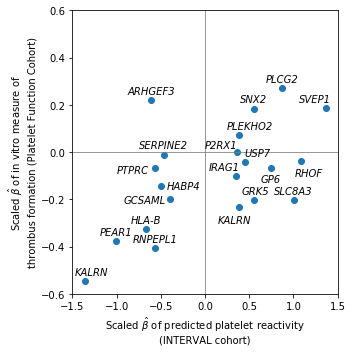

In [58]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'auto'},figsize=(5,5))

ax.scatter(comp["BETA_INTERVAL"],comp["BETA_HSK"])
#ax.errorbar(comp["BETA_INTERVAL"],comp["BETA_haemskerk"],
#            yerr=comp["SE"] / 2,
#            elinewidth=.3,
#            #els=":",
#            ls='none') #c=np.log10(comp["P_haemskerk"])
ax.axvline(0,ls='-',c="grey",lw=.8)
ax.axhline(0,ls='-',c="grey",lw=.8)

ax.set_xlabel("Scaled $\hat{\\beta}$ of predicted platelet reactivity \n(INTERVAL cohort)")
ax.set_ylabel("Scaled $\hat{\\beta}$ of in vitro measure of\nthrombus formation (Platelet Function Cohort)")

known_genes = ["GP6","PEAR1","IRAG1","GRK5","ARHGEF3","SVEP1"]

shifts = {"SVEP1":[-.12,0.],
          "PLCG2":[0.,.0],
          "GP6":[0.,-.083],
          "PLEKHO2":[0.12,0.],
          "P2RX1":[-.19,-.009],
          "IRAG1":[-.14,0.],
          "KALRN":[-.02,.01],
          "USP7":[.15,0.],
          "SERPINE2":[0.,.001],
          "HABP4":[.26,-.04],
          "ARHGEF3":[.0,0.],
          "GCSAML":[-.28,-0.04],
          "HLA-B":[0.,0.],
          "RNPEPL1":[0.,0.],
          "PTPRC": [-0.25,-.045],
          "KALRN_1":[-.05,-0.09],
          "SNX2":[0.0,.0],
          "RHOF":[0.09,-0.09],
          "GRK5":[.009,0.],
          "KALRN_2":[.07,0.]}

links = {}

for i, row in comp.iterrows():
    if row["SYMBOL"] in shifts:
        shift_x,shift_y = shifts[row["SYMBOL"]]
    else:
        shift_x,shift_y = 0,0
        
    if row["SYMBOL"] == "KALRN":
        if row["BETA_INTERVAL"] > 0:
            shift_x,shift_y = shifts["KALRN_1"]
        else:
            shift_x,shift_y = shifts["KALRN_2"]
    
    #weight = "bold" if row["SYMBOL"] in known_genes else None
    weight = None
    if row["SYMBOL"] in links:
        ax.plot([row["BETA_INTERVAL"],row["BETA_INTERVAL"] + links[row["SYMBOL"]][0]],
                [row["BETA_HSK"],row["BETA_HSK"] + links[row["SYMBOL"]][1]],c="grey",lw=.5)
        shift_x += links[row["SYMBOL"]][0]
        shift_y += links[row["SYMBOL"]][1]
    ax.text(row["BETA_INTERVAL"]+shift_x,
            .025+row["BETA_HSK"]+shift_y,row["SYMBOL"],
            ha="center",style="italic",weight=weight)

plt.xlim((-1.5,1.5))
plt.ylim((-0.6,0.6))
    
plt.tight_layout()
plt.savefig("figures/beta_microfluidic.pdf")

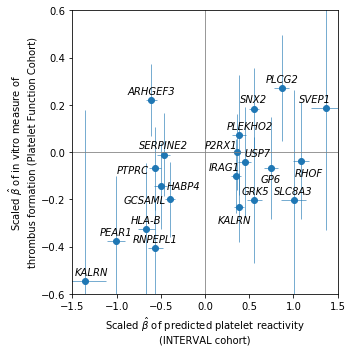

In [59]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'auto'},figsize=(5,5))

ax.scatter(comp["BETA_INTERVAL"],comp["BETA_HSK"])
ax.errorbar(comp["BETA_INTERVAL"],comp["BETA_HSK"],
            yerr=comp["SE_HSK"],
            xerr=comp["SE_INTERVAL"],
            elinewidth=.6,
            #els=":",
            ls='none') #c=np.log10(comp["P_haemskerk"])
ax.axvline(0,ls='-',c="grey",lw=.8)
ax.axhline(0,ls='-',c="grey",lw=.8)

ax.set_xlabel("Scaled $\hat{\\beta}$ of predicted platelet reactivity \n(INTERVAL cohort)")
ax.set_ylabel("Scaled $\hat{\\beta}$ of in vitro measure of\nthrombus formation (Platelet Function Cohort)")

known_genes = ["GP6","PEAR1","IRAG1","GRK5","ARHGEF3","SVEP1"]

shifts = {"SVEP1":[-.12,0.],
          "PLCG2":[0.,.0],
          "GP6":[0.,-.083],
          "PLEKHO2":[0.12,0.],
          "P2RX1":[-.19,-.009],
          "IRAG1":[-.14,0.],
          "USP7":[.15,0.],
          "SERPINE2":[0.,.001],
          "HABP4":[.26,-.04],
          "ARHGEF3":[.0,0.],
          "GCSAML":[-.28,-0.04],
          "HLA-B":[0.,0.],
          "RNPEPL1":[0.,0.],
          "PTPRC": [-0.25,-.045],
          "KALRN_1":[-.05,-0.09],
          "SNX2":[0.0,.0],
          "RHOF":[0.09,-0.09],
          "GRK5":[.009,0.],
          "KALRN_2":[.07,0.]}

links = {}

for i, row in comp.iterrows():
    if row["SYMBOL"] in shifts:
        shift_x,shift_y = shifts[row["SYMBOL"]]
    else:
        shift_x,shift_y = 0,0
        
    if row["SYMBOL"] == "KALRN":
        if row["BETA_INTERVAL"] > 0:
            shift_x,shift_y = shifts["KALRN_1"]
        else:
            shift_x,shift_y = shifts["KALRN_2"]
    
    #weight = "bold" if row["SYMBOL"] in known_genes else None
    weight = None
    if row["SYMBOL"] in links:
        ax.plot([row["BETA_INTERVAL"],row["BETA_INTERVAL"] + links[row["SYMBOL"]][0]],
                [row["BETA_HSK"],row["BETA_HSK"] + links[row["SYMBOL"]][1]],c="grey",lw=.5)
        shift_x += links[row["SYMBOL"]][0]
        shift_y += links[row["SYMBOL"]][1]
    ax.text(row["BETA_INTERVAL"]+shift_x,
            .025+row["BETA_HSK"]+shift_y,row["SYMBOL"],
            ha="center",style="italic",weight=weight)

plt.xlim((-1.5,1.5))
plt.ylim((-0.6,0.6))
    
plt.tight_layout()
plt.savefig("figures/beta_microfluidic_err.pdf")

In [139]:
proxies

{'rs11078475': '17:3819002[b37]T,C', 'rs1654425': '19:55538980[b37]T,C'}

In [75]:
comp = pd.merge(df.loc[df.pheno == "raw_PC_1"], gene_hits,left_on="ID",right_on="INTERVAL_SNP",how="inner",suffixes=("_haemskerk","_interval"))
export_comp = comp[["#CHROM","POS_haemskerk","ID_haemskerk","BETA_haemskerk","SE","P_haemskerk","REF_haemskerk","ALT_haemskerk"]].copy()
export_comp["BETA_haemskerk"] *= -1
export_comp[["REF_haemskerk","ALT_haemskerk"]] = export_comp[["ALT_haemskerk","REF_haemskerk"]]
for rsID, ID in proxies.items():
    export_comp.loc[export_comp["ID_haemskerk"] == rsID,"ID_haemskerk"] = "%s (proxy for %s)" % (ID,rsID)

In [77]:
df.loc[df.pheno == "raw_PC_1"]

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,pheno
0,1,156869047,rs12566888,G,T,T,ADD,87,-0.377892,0.277370,-1.362410,0.176710,raw_PC_1
1,1,199010721,rs1434282,C,T,C,ADD,87,0.067932,0.174940,0.388317,0.698764,raw_PC_1
2,1,247712303,rs41315846,T,C,C,ADD,87,-0.200141,0.158098,-1.265930,0.209037,raw_PC_1
24,2,224874874,rs13412535,G,A,A,ADD,87,-0.010060,0.174254,-0.057734,0.954097,raw_PC_1
25,2,241510903,rs78909033,G,A,A,ADD,87,-0.405599,0.210133,-1.930200,0.056957,raw_PC_1
40,3,56849749,rs1354034,T,C,T,ADD,87,-0.219246,0.152107,-1.441400,0.153190,raw_PC_1
41,3,124340093,rs13067286,G,A,A,ADD,87,-0.233964,0.144103,-1.623590,0.108211,raw_PC_1
42,3,124366890,rs76445378,C,T,T,ADD,87,-0.544849,0.721735,-0.754916,0.452411,raw_PC_1
64,5,122088890,rs922140,A,G,A,ADD,87,-0.184712,0.170255,-1.084920,0.281063,raw_PC_1
72,6,31323065,rs3819288,G,C,C,ADD,87,-0.326438,0.280602,-1.163350,0.247983,raw_PC_1


In [224]:
export_comp.rename(
    columns={
        "POS_haemskerk":"POS",
        "ID_haemskerk":"SNP",
        "BETA_haemskerk":"BETA",
        "P_haemskerk":"P",
        "REF_haemskerk":"REF",
        "ALT_haemskerk":"ALT"}).to_excel("supplementary_tables/heemskerk_glm.xlsx")

In [225]:
export_comp

,#CHROM,POS_haemskerk,ID_haemskerk,BETA_haemskerk,SE,P_haemskerk,REF_haemskerk,ALT_haemskerk
0,1,156869047,rs12566888,0.377892,0.277370,0.176710,T,G
1,1,199010721,rs1434282,-0.067932,0.174940,0.698764,T,C
2,1,247712303,rs41315846,0.200141,0.158098,0.209037,C,T
3,2,224874874,rs13412535,0.010060,0.174254,0.954097,A,G
4,2,241510903,rs78909033,0.405599,0.210133,0.056957,A,G
5,3,56849749,rs1354034,0.219246,0.152107,0.153190,C,T
6,3,124340093,rs13067286,0.233964,0.144103,0.108211,A,G
7,3,124366890,rs76445378,0.544849,0.721735,0.452411,T,C
8,5,122088890,rs922140,0.184712,0.170255,0.281063,G,A
9,6,31323065,rs17881225 (proxy for rs3819288),0.326438,0.280602,0.247983,C,G


# Link between Haemskirt and PFC phenotypes

In [369]:
pfc_pheno = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/pfc_phenotypes/phenotypes.tsv", sep="\t")

In [394]:
pfc_pheno.loc[pfc_pheno.Affy.isin(pheno.affy_ID.tolist())]

,Affy,REST,ADP,CRP,PAR1,PAR4,TRAP,ADP_FIB_ONLY
209,a550484-4324983-042818-483_A01.CEL,0.687399,0.677670,-1.188243,1.109369,0.677750,0.791210,NaN
210,a550484-4324983-042818-483_A02.CEL,0.612592,1.472463,1.113782,-0.792841,0.404713,-0.539925,NaN
211,a550484-4324983-042818-483_A03.CEL,0.647501,-0.265967,0.697171,1.190001,0.394193,0.564925,NaN
212,a550484-4324983-042818-483_A04.CEL,0.678733,-0.642562,-0.875948,-0.201996,0.934021,-0.083166,NaN
219,a550484-4324983-042818-483_B01.CEL,-1.232007,0.005695,-0.688687,0.273197,-0.136854,-0.221682,NaN
...,...,...,...,...,...,...,...,...
1225,a550484-4327674-062018-906_C01.CEL,0.396089,-0.560413,-0.918280,-0.675703,0.341128,-0.413330,NaN
1235,a550484-4327674-062018-906_D01.CEL,-1.737347,-0.170840,0.403141,-0.912314,-0.076417,-0.923517,NaN
1245,a550484-4327674-062018-906_E01.CEL,1.039399,0.118011,-0.152895,-1.312096,-0.272329,-0.935873,NaN
1256,a550484-4327674-062018-906_F01.CEL,1.115781,0.542311,1.278787,1.249618,1.587572,0.984875,NaN


In [398]:
pheno.shape

(187, 72)

In [399]:
comp = pd.merge(pfc_pheno, export_pheno,left_on="Affy",right_on="IID")

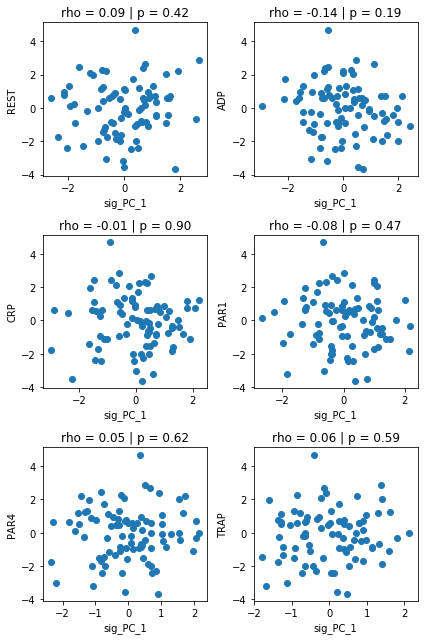

In [400]:
pfc_cols = ["REST","ADP","CRP","PAR1","PAR4","TRAP"]
fig = plt.figure(figsize=(6,9))
hc = pc_cols[0]
for i, pc in enumerate(pfc_cols):
    ax = fig.add_subplot(3,2,i+1)
    ax.set_ylabel(pc)
    ax.set_xlabel(hc)
    ax.scatter(comp[pc],comp[hc])
    good = ~comp[pc].isnull() & ~comp[hc].isnull()
    ax.set_title("rho = %.2f | p = %.2f" % pearsonr(comp.loc[good,pc],comp.loc[good,hc]))
plt.tight_layout()